## Why Semantic Search ?

Semantic search represents an advanced approach to search queries that focuses on understanding the context and intent behind a user's query, rather than relying solely on matching keywords. By leveraging natural language processing (NLP) and machine learning techniques, semantic search can interpret and analyze the nuances and meanings of words within the context, offering more accurate and relevant results. This capability makes it particularly valuable for addressing business problems, as it enhances user experience, improves the accuracy of search results, and boosts engagement by effectively understanding and responding to user needs. For businesses, implementing semantic search can lead to increased customer satisfaction, higher conversion rates, and a competitive edge in delivering content or products that truly meet user intentions and expectations.

### Data Collection & Wikipedia API

Through API calls, data was collected through the `wikipediaapi` python package [wikipedia-api](https://pypi.org/project/Wikipedia-API/). 

I chose to pull the `'Featured articles'` for this particular project as they consist of the highest quality data maintained by wiki editors. I provide a simple python script where you can call the Wikipedia API and collect your own data here with some slight modifications: [get_wiki_articles.py](get_wiki_articles.py)

It's important to follow the etiquette guideline when extracting/parsing data from Wikipedia. You should take time between requests or implement some form of rate limiting. It is not necessary to web scrape as you can collect quite a large amount of data in a short period through calling the API and Wikipedia prefers you to not web scrape and use the API instead. [API:Main](https://www.mediawiki.org/wiki/API:Main_page)

Refer to the etiquette guide here: [API:Etiquette](https://www.mediawiki.org/wiki/API:Etiquette) 

Data mining/extraction notebook can be found here if preferred over py script: [Data Collection](https://github.com/pyamin1878/Semantico/blob/main/notebooks/data_extraction.ipynb)

### Dataset

Full dataset is located in the repository in `json` format: [dataset](https://github.com/pyamin1878/Semantico/blob/main/data/wiki_corpus.zip)

### Data Cleaning & Preprocessing 

Data cleaning, preprocessing, and tokenization notebook: [data_cleaning_preproccesing](https://github.com/pyamin1878/Semantico/blob/main/notebooks/data_cleaning_preprocessing.ipynb)

#### Data Cleaning 
**Lowercasing Text**: Standardizing the case of the text to lowercase.

**Removing Special Characters and Punctuation**: Using `regex` to retain only alphanumeric characters and spaces, thus removing any form of punctuation or special characters.

**Replacing Line Breaks**: Converting newline characters `\n` into spaces to maintain sentence continuity.

This process was encapsulated within a `clean_text` function, which was then applied to the dataset to produce a cleaned version.

#### Data Preprocessing Steps

**Tokenization**: Splitting the cleaned text into individual words or tokens using NLTK's `word_tokenize`.

**Stop Word Removal**: Eliminating common words that add little value to the analysis, such as "the", "is", etc., using NLTK's predefined list of stop words.

**Lemmatization**: Converting words to their base form, thus reducing the complexity of the vocabulary and consolidating similar forms of a word (e.g., "planning" to "plan"), using NLTK's `WordNetLemmatizer`.

### SentencePiece Tokenizer
|*"SentencePiece is an unsupervised text tokenizer and detokenizer mainly for Neural Network-based text generation systems where the vocabulary size is predetermined prior to the neural model training."*|
|:--:|



`SentencePiece` utilizes byte-pair encoding or `BPE` and in my provided [notebook](https://github.com/pyamin1878/Semantico/blob/main/notebooks/data_cleaning_preprocessing.ipynb), SentencePiece was employed to tokenize the preprocessed text data, showcasing its efficacy in creating a manageable and effective representation of text for machine learning models.

The `SentencePieceTrainer.train()` function was used with specified parameters such as input file, model prefix, and vocabulary size. This step is crucial as it adapts the model to the dataset's specific linguistic characteristics.

The `SentencePiece` model was then utilized to tokenize text into subwords or symbols, breaking down complex words into more manageable, model-friendly units. 

For a deeper dive into `BPE` and lossless tokenization refer to the blog post here: 

[Sentencepiece: A simple and language-independent subword tokenizer and detokenizer for neural text processing](https://medium.com/codex/sentencepiece-a-simple-and-language-independent-subword-tokenizer-and-detokenizer-for-neural-text-ffda431e704e)

### Modeling

Modeling including `Topic Modeling` and iterative process can be found in this notebook in the repo: [modeling](https://github.com/pyamin1878/Semantico/blob/main/notebooks/Modeling.ipynb)  

### Best Model for Semantic Search

#### Sentence Transformers 

`SentenceTransformers` is a python framework for state-of-the-art sentence, text and image embeddings. The initial research is described in the paper "Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks". [Sentence-BERT](https://arxiv.org/abs/1908.10084)

The framework can compute sentence and text embeddings for over 100 languages. 

I used these embeddings with cosine-similarity to find sentences with similar meaning, enabling semantic textual similarity and search.

`SentenceTransformers` is built on `PyTorch` and Transformers architecture. It offers many pre-trained models tuned for various tasks.

In [ ]:
# !pip install sentence-transformers

#### Let's install and setup our `sentence-transformers` pipeline

In [2]:
from sentence_transformers import SentenceTransformer

# Load the model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Load preproceesed text data
documents = []
with open('preprocessed_data.txt', 'r', encoding='utf-8') as file:
    documents = file.read().splitlines()

# Generate embeddings
embeddings = model.encode(documents, show_progress_bar=True)

print("Embeddings generated for the text data.")

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

Batches:   0%|          | 0/201 [00:00<?, ?it/s]

Embeddings generated for the text data.


In [3]:
print(f"Total documents loaded: {len(documents)}")
print("\nFirst few documents:")
for doc in documents[:5]:
    print(doc)
    print("---")

Total documents loaded: 6428

First few documents:
? (film) also written tanda tanya meaning question mark 2011 indonesian drama film directed hanung bramantyo star revalina sayuthi temat reza rahadian agus kuncoro endhita rio dewanto hengky sulaeman film focus around indonesia religious pluralism often result conflict different belief represented plot revolves around interaction three family one buddhist one muslim one catholic undergoing numerous hardship death several family member religious violence reconciled based bramantyos experience mixedrace child meant counter portrayal islam radical religion owing film theme religious pluralism controversial subject matter bramantyo difficulty finding backing eventually mahaka picture put forth rp 5 billion 600000 fund production filming began 5 january 2011 semarang released 7 april 2011 critical commercial success received favourable review viewed 550000 people screened internationally nominated nine citra award 2011 indonesian film festi

##### Creating a custom function to calculate our `cosine_similarity`

In [4]:
import numpy as np

# Cosine Similarity Function
def cosine_similarity(vec_a, vec_b):
    """Calculate the cosine similarity between two vectors."""
    cos_sim = np.dot(vec_a, vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
    return cos_sim

##### A custom search function with parameters to retrieve relevant docs based on `cosine_similarity` score

In [5]:
# Search Function
def search(query, model, documents, embeddings, top_n):
    """
    Search the documents for the given query.

    Parameters:
    - query: The search query string.
    - model: The sentence transformer model for embedding.
    - documents: A list of articles
    - embeddings: The word embeddings for the documents.
    - top_n: Number of top results to return.

    Returns:
    - A list of tuples (document, score) sorted by relevance to the query.
    """
    # Generate the query embedding
    query_embedding = model.encode([query])[0]
    
    # Calculate similarities with all document embeddings
    similarities = np.array([cosine_similarity(query_embedding, doc_embedding) for doc_embedding in embeddings])
    
    # Get the top N most similar document indices
    top_indices = np.argsort(similarities)[::-1][:top_n]
    
    # Retrieve the top N most similar documents and their scores
    top_documents_scores = [(documents[idx], similarities[idx]) for idx in top_indices]
    
    return top_documents_scores

In [28]:
# Search query
query = "55 wall st"

top_n = 3  # Number of results to return
top_results = search(query, model, documents, embeddings, top_n)

for doc, score in top_results:
    print(f"Document: {doc}, Score: {score:.4f}")

Document: 55 Wall Street 55 wall street formerly national city bank building eightstory building wall street william hanover street financial district lower manhattan new york city new york united state lowest three story completed either 1841 1842 fourstory merchant exchange designed isaiah rogers greek revival style 1907 1910 mckim mead white removed original fourth story added five floor create present building facade part interior new york city designated landmark building listed new york state register historic place national register historic place nrhp national historic landmark also contributing property wall street historic district listed nrhp 55 wall street granite facade includes two stacked colonnade facing wall street twelve column inside cruciform banking hall 60foot 18 vaulted ceiling corinthian column marble floor wall entablature around interior banking hall among largest united state completed office citibanks predecessor national city bank corner banking hall fourth

In [29]:
# Search query
query = "fountain of time"

top_n = 3  # Number of results to return
top_results = search(query, model, documents, embeddings, top_n)

for doc, score in top_results:
    print(f"Document: {doc}, Score: {score:.4f}")

Document: Fountain of Time fountain time simply time sculpture lorado taft measuring 126 foot 10 inch 3866 length situated western edge midway plaisance within washington park chicago illinois united state sculpture inspired henry austin dobson poem paradox time 100 figure passing father time created monument 100 year peace united state united kingdom following treaty ghent 1814 father time face 100 across water basin fountain water turned 1920 sculpture dedicated 1922 contributing structure washington park united state registered historic district national register historic place listing part larger beautification plan midway plaisance time constructed new type molded steelreinforced concrete claimed durable cheaper alternative said first kind finished work art made concrete completion millennium park 2004 considered important art installation chicago park district time one several chicago work art funded benjamin fergusons trust fund time undergone several restoration deterioration d

In [30]:
# Search query
query = "easter brown snake"

top_n = 3  # Number of results to return
top_results = search(query, model, documents, embeddings, top_n)

for doc, score in top_results:
    print(f"Document: {doc}, Score: {score:.4f}")

Document: Eastern brown snake eastern brown snake pseudonaja textilis often referred common brown snake specie extremely venomous snake family elapidae specie native eastern central australia southern new guinea first described andr marie constant dumril gabriel bibron auguste dumril 1854 adult eastern brown snake slender build grow 2 7 ft length colour surface range pale brown black underside pale creamyellow often orange grey splotch eastern brown snake found habitat except dense forest often farmland outskirt urban area place populated main prey house mouse specie oviparous international union conservation nature classifies snake leastconcern specie though status new guinea unclear considered world secondmost venomous land snake inland taipan oxyuranus microlepidotus based ld50 value subcutaneous mouse main effect venom circulatory systemcoagulopathy haemorrhage bleeding cardiovascular collapse cardiac arrest one main component venom prothrombinase complex pseutarinc break prothromb

In [31]:
# Search query
query = "super mario"

top_n = 3  # Number of results to return
top_results = search(query, model, documents, embeddings, top_n)

for doc, score in top_results:
    print(f"Document: {doc}, Score: {score:.4f}")

Document: New Super Mario Bros. new super mario bros 2006 platform video game developed published nintendo nintendo d first released may 2006 north america japan pal region june 2006 first installment new super mario bros subseries super mario franchise follows mario fight way bowsers henchman rescue princess peach mario access several old new powerups help complete quest including super mushroom fire flower super star giving unique ability traveling eight world 80 level mario must defeat bowser jr bowser saving princess peach new super mario bros commercially critically successful praise went towards game improvement introduction made mario franchise faithfulness older mario game criticism targeted low difficulty level lingering similarity previous game called one best game available nintendo d several critic calling one best sidescrolling super mario title sold 30 million copy worldwide making bestselling game nintendo d one bestselling video game time game success led line sequel re

In [10]:
!pip install rank_bm25

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [6]:
from rank_bm25 import BM25Okapi
from sklearn.feature_extraction import _stop_words
import string
from tqdm.autonotebook import tqdm
import torch

In [7]:
from sentence_transformers import SentenceTransformer, CrossEncoder, util

if not torch.cuda.is_available():
    print("Warning: No GPU found. Please add GPU to your notebook")


# bi-Encoder to encode all passages, so that we can use it with semantic search
bi_encoder = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')
bi_encoder.max_seq_length = 256     # Truncate long passages to 256 tokens
top_k = 32                          # Number of passages we want to retrieve with the bi-encoder

#The bi-encoder will retrieve 100 documents. and then a cross-encoder, to re-rank the results list to improve the quality
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

README.md:   0%|          | 0.00/11.6k [00:00<?, ?B/s]

In [8]:
corpus_embeddings = bi_encoder.encode(documents, convert_to_tensor=True, show_progress_bar=True)

Batches:   0%|          | 0/201 [00:00<?, ?it/s]

### Retrieval and Reranking 

![alt text](images/Retrieval_Reranking.png)

In order to improve our semantic search, cross-encoders and bi-encoder models were implemented in a search pipeline with multiple models from `huggingface` hub:

[Bi-Encoder Model](https://huggingface.co/sentence-transformers/multi-qa-MiniLM-L6-cos-v1)

[Cross-Encoder Model](https://huggingface.co/cross-encoder/ms-marco-MiniLM-L-6-v2)

Chaining these two pre-trained models for complex search tasks can significantly improve semantic search as demonstrated by the custom pipeline built to retrieve our documents in our text corpus. Documentation on retrieval and reranking within the `SentenceTransformers` library can be found through the `SBERT` docs here: 

[Retrieval and Reranking](https://www.sbert.net/examples/applications/retrieve_rerank/README.html)

In [9]:
def retrieve_rerank(query, bi_encoder, cross_encoder, documents, corpus_embeddings):
    print("Input question:", query)
    
    ##### Semantic Search #####
    # Encode the query using the bi-encoder and find potentially relevant passages
    question_embedding = bi_encoder.encode(query, convert_to_tensor=True)
    # If using a model that supports CUDA, uncomment the following line
    question_embedding = question_embedding.cuda()
    hits = util.semantic_search(question_embedding, corpus_embeddings, top_k=top_k)
    hits = hits[0]  # Get the hits for the first query

   
    ##### Re-Ranking #####
    # Now, score all retrieved passages with the cross_encoder
    cross_inp = [[query, documents[hit['corpus_id']]] for hit in hits]
    cross_scores = cross_encoder.predict(cross_inp)

    # Sort results by the cross-encoder scores
    for idx in range(len(hits)):
        hits[idx]['cross-score'] = cross_scores[idx]

    print("\n-------------------------\n")
    print("Top-3 Bi-Encoder Retrieval hits")
    hits = sorted(hits, key=lambda x: x['score'], reverse=True)
    for hit in hits[:3]:
        print("\t{:.3f}\t{}".format(hit['score'], documents[hit['corpus_id']].replace("\n", " ")))

    print("\n-------------------------\n")
    print("Top-3 Cross-Encoder Re-ranker hits")
    hits = sorted(hits, key=lambda x: x['cross-score'], reverse=True)
    for hit in hits[:3]:
        print("\t{:.3f}\t{}".format(hit['cross-score'], documents[hit['corpus_id']].replace("\n", " ")))

##### Let's give an example query here "coldest place on earth" and then cross-check the top search hit from the `bi_encoder` and `cross_encoder`

In [24]:
retrieve_rerank(query = "Coldest place earth", bi_encoder=bi_encoder, cross_encoder=cross_encoder, documents=documents, corpus_embeddings=corpus_embeddings)

Input question: Coldest place earth

-------------------------

Top-3 Bi-Encoder Retrieval hits
	0.557	Antarctica antarctica earth southernmost leastpopulated continent situated almost entirely south antarctic circle surrounded southern ocean also known antarctic ocean contains geographic south pole antarctica fifthlargest continent 40 larger europe area 14200000 km2 5500000 sq mi antarctica covered antarctic ice sheet average thickness 19 km 12 mi antarctica average coldest driest windiest continent highest average elevation mainly polar desert annual precipitation 200 mm 8 along coast far le inland 70 world freshwater reserve frozen antarctica melted would raise global sea level almost 60 metre 200 ft antarctica hold record lowest measured temperature earth 892 c 1286 f coastal region reach temperature 10 c 50 f summer native specie animal include mite nematode penguin seal tardigrade vegetation occurs mostly form lichen moss ice shelf antarctica probably first seen 1820 russian expe

In [39]:
from collections import Counter
import re

retrieved_texts = [hit[0] for hit in hits]  # Extracting the document text from each hit
combined_text = " ".join(retrieved_texts)

# Tokenize and count word frequencies
words = re.findall(r'\w+', combined_text.lower())  # Convert to lowercase and tokenize
word_counts = Counter(words)

# Get the most common words
most_common_words = word_counts.most_common(10)  # Adjust the number as needed

# Print the most frequent words
for word, count in most_common_words:
    print(f"{word}: {count}")

mario: 280
game: 256
super: 213
nintendo: 91
bros: 87
world: 84
new: 65
player: 56
level: 48
snes: 39


In [44]:
# Analyzing the second retrieved document (index 1)
document_text = hits[1][0] 
word_counts = get_word_frequencies(document_text)
most_common_words = word_counts.most_common(10) 

print("Most Frequent Words in the Selected Document:")
for word, count in most_common_words:
    print(f"{word}: {count}")

Most Frequent Words in the Selected Document:
mario: 96
super: 79
game: 66
nintendo: 38
bros: 31
allstars: 28
level: 25
compilation: 22
snes: 18
player: 17


In [47]:
# Search query
query = "easter brown snake"

top_n = 3  # Number of results to return
hits = search(query, model, documents, embeddings, top_n)

for doc, score in top_results:
    print(f"Document: {doc}, Score: {score:.4f}")

Document: Eastern brown snake eastern brown snake pseudonaja textilis often referred common brown snake specie extremely venomous snake family elapidae specie native eastern central australia southern new guinea first described andr marie constant dumril gabriel bibron auguste dumril 1854 adult eastern brown snake slender build grow 2 7 ft length colour surface range pale brown black underside pale creamyellow often orange grey splotch eastern brown snake found habitat except dense forest often farmland outskirt urban area place populated main prey house mouse specie oviparous international union conservation nature classifies snake leastconcern specie though status new guinea unclear considered world secondmost venomous land snake inland taipan oxyuranus microlepidotus based ld50 value subcutaneous mouse main effect venom circulatory systemcoagulopathy haemorrhage bleeding cardiovascular collapse cardiac arrest one main component venom prothrombinase complex pseutarinc break prothromb

In [48]:
from collections import Counter
import re

retrieved_texts = [hit[0] for hit in hits]  # Extracting the document text from each hit
combined_text = " ".join(retrieved_texts)

# Tokenize and count word frequencies
words = re.findall(r'\w+', combined_text.lower())  # Convert to lowercase and tokenize
word_counts = Counter(words)

# Get the most common words
most_common_words = word_counts.most_common(10) 

# Print the most frequent words
for word, count in most_common_words:
    print(f"{word}: {count}")

snake: 284
brown: 130
eastern: 59
specie: 55
venom: 53
black: 52
australia: 45
king: 42
redbellied: 35
scale: 32


In [49]:
from collections import Counter
import re

# Function to tokenize and count word frequencies in a document
def get_word_frequencies(text):
    words = re.findall(r'\w+', text.lower())  # Tokenize and convert to lowercase
    word_counts = Counter(words)
    return word_counts

# Loop through each hit and analyze word frequencies individually
for i, hit in enumerate(hits):
    document_text = hit[0]  # Extracting the document text
    word_counts = get_word_frequencies(document_text)
    most_common_words = word_counts.most_common(10)  
    
    print(f"Document {i+1} Most Frequent Words:")
    for word, count in most_common_words:
        print(f"{word}: {count}")
    print("\n---\n")

Document 1 Most Frequent Words:
snake: 121
brown: 69
eastern: 51
venom: 28
new: 21
specie: 20
australia: 13
found: 13
scale: 13
area: 12

---

Document 2 Most Frequent Words:
snake: 100
brown: 57
king: 42
australia: 22
specie: 20
venom: 17
p: 16
victim: 14
mulga: 12
scale: 12

---

Document 3 Most Frequent Words:
snake: 63
black: 43
redbellied: 35
specie: 15
may: 11
australia: 10
water: 10
bite: 9
body: 9
generally: 8

---



In [63]:
retrieve_rerank(query = "second world war", bi_encoder=bi_encoder, cross_encoder=cross_encoder, documents=documents, corpus_embeddings=corpus_embeddings)

Input question: second world war

-------------------------

Top-3 Bi-Encoder Retrieval hits
	0.553	Operation Hardboiled operation hardboiled second world war military deception undertaken ally 1942 first attempt deception london controlling section lcs designed convince axis power ally would soon invade germanoccupied norway lcs recently established plan deception across theatre struggled support unenthusiastic military establishment lcs little guidance strategic deception activity pioneered dudley clarke previous year unaware extensive double agent system controlled mi5 result hardboiled planned real operation rather fictional one clarke already found approach wasteful time resource preferring present story using agent wireless traffic resistance operation chosen unit meant much preparation completed adolf hitler ordered reinforcement scandinavia march april 1942 hardboiled shelved may unclear extent operation contributed decision despite limited impact operation gave lcs experience 

In [11]:
retrieve_rerank(query = "most poisonous frog", bi_encoder=bi_encoder, cross_encoder=cross_encoder, documents=documents, corpus_embeddings=corpus_embeddings)

Input question: most poisonous frog

-------------------------

Top-3 Bi-Encoder Retrieval hits
	0.487	Frog frog member diverse largely carnivorous group shortbodied tailless amphibian composing order anura literally without tail ancient greek oldest fossil protofrog triadobatrachus known early triassic madagascar molecular clock dating suggests split amphibian may extend back permian 265 million year ago frog widely distributed ranging tropic subarctic region greatest concentration specie diversity tropical rainforest frog account around 88 extant amphibian specie also one five diverse vertebrate order warty frog specie tend called toad distinction frog toad informal taxonomy evolutionary history adult frog stout body protruding eye anteriorlyattached tongue limb folded underneath tail tail tailed frog extension male cloaca frog glandular skin secretion ranging distasteful toxic skin varies colour wellcamouflaged dappled brown grey green vivid pattern bright red yellow black show toxi

## Conclusions

This project embarked on the ambitious goal of enhancing search capabilities through semantic search, focusing on understanding the context and intent behind user queries. By leveraging advanced natural language processing techniques, we aimed to move beyond keyword matching to a more nuanced and intelligent search experience.

### Key Findings

- The implementation of semantic search, particularly through the retrieval and re-ranking method, demonstrated a significant improvement in the relevance and accuracy of search results. This method's ability to parse and understand query intent led to a more intuitive experience.
- Comparative analysis with traditional search methods highlighted the superiority of semantic search in handling complex queries and returning contextually relevant results.
- The use of for retrieval and re-ranking provided insights into the potential of NLP/ML to transform search technologies.

### Project Impact

The findings from this project underscore the potential of semantic search to redefine how we interact with information systems. By prioritizing context and semantic understanding, we can create more responsive, intuitive, and user-friendly search experiences. This approach not only improves user satisfaction but also paves the way for future innovations in search technology.

### Deployment and Stretch Goals

Build a RAG (Retrieveal Augmented Generation) pipeline to retrieve relevant documents and then subsequently summarize text for an end to end pleasant user-experience. Deployment will be made via Streamlit or fastapi backend with React frontend. 

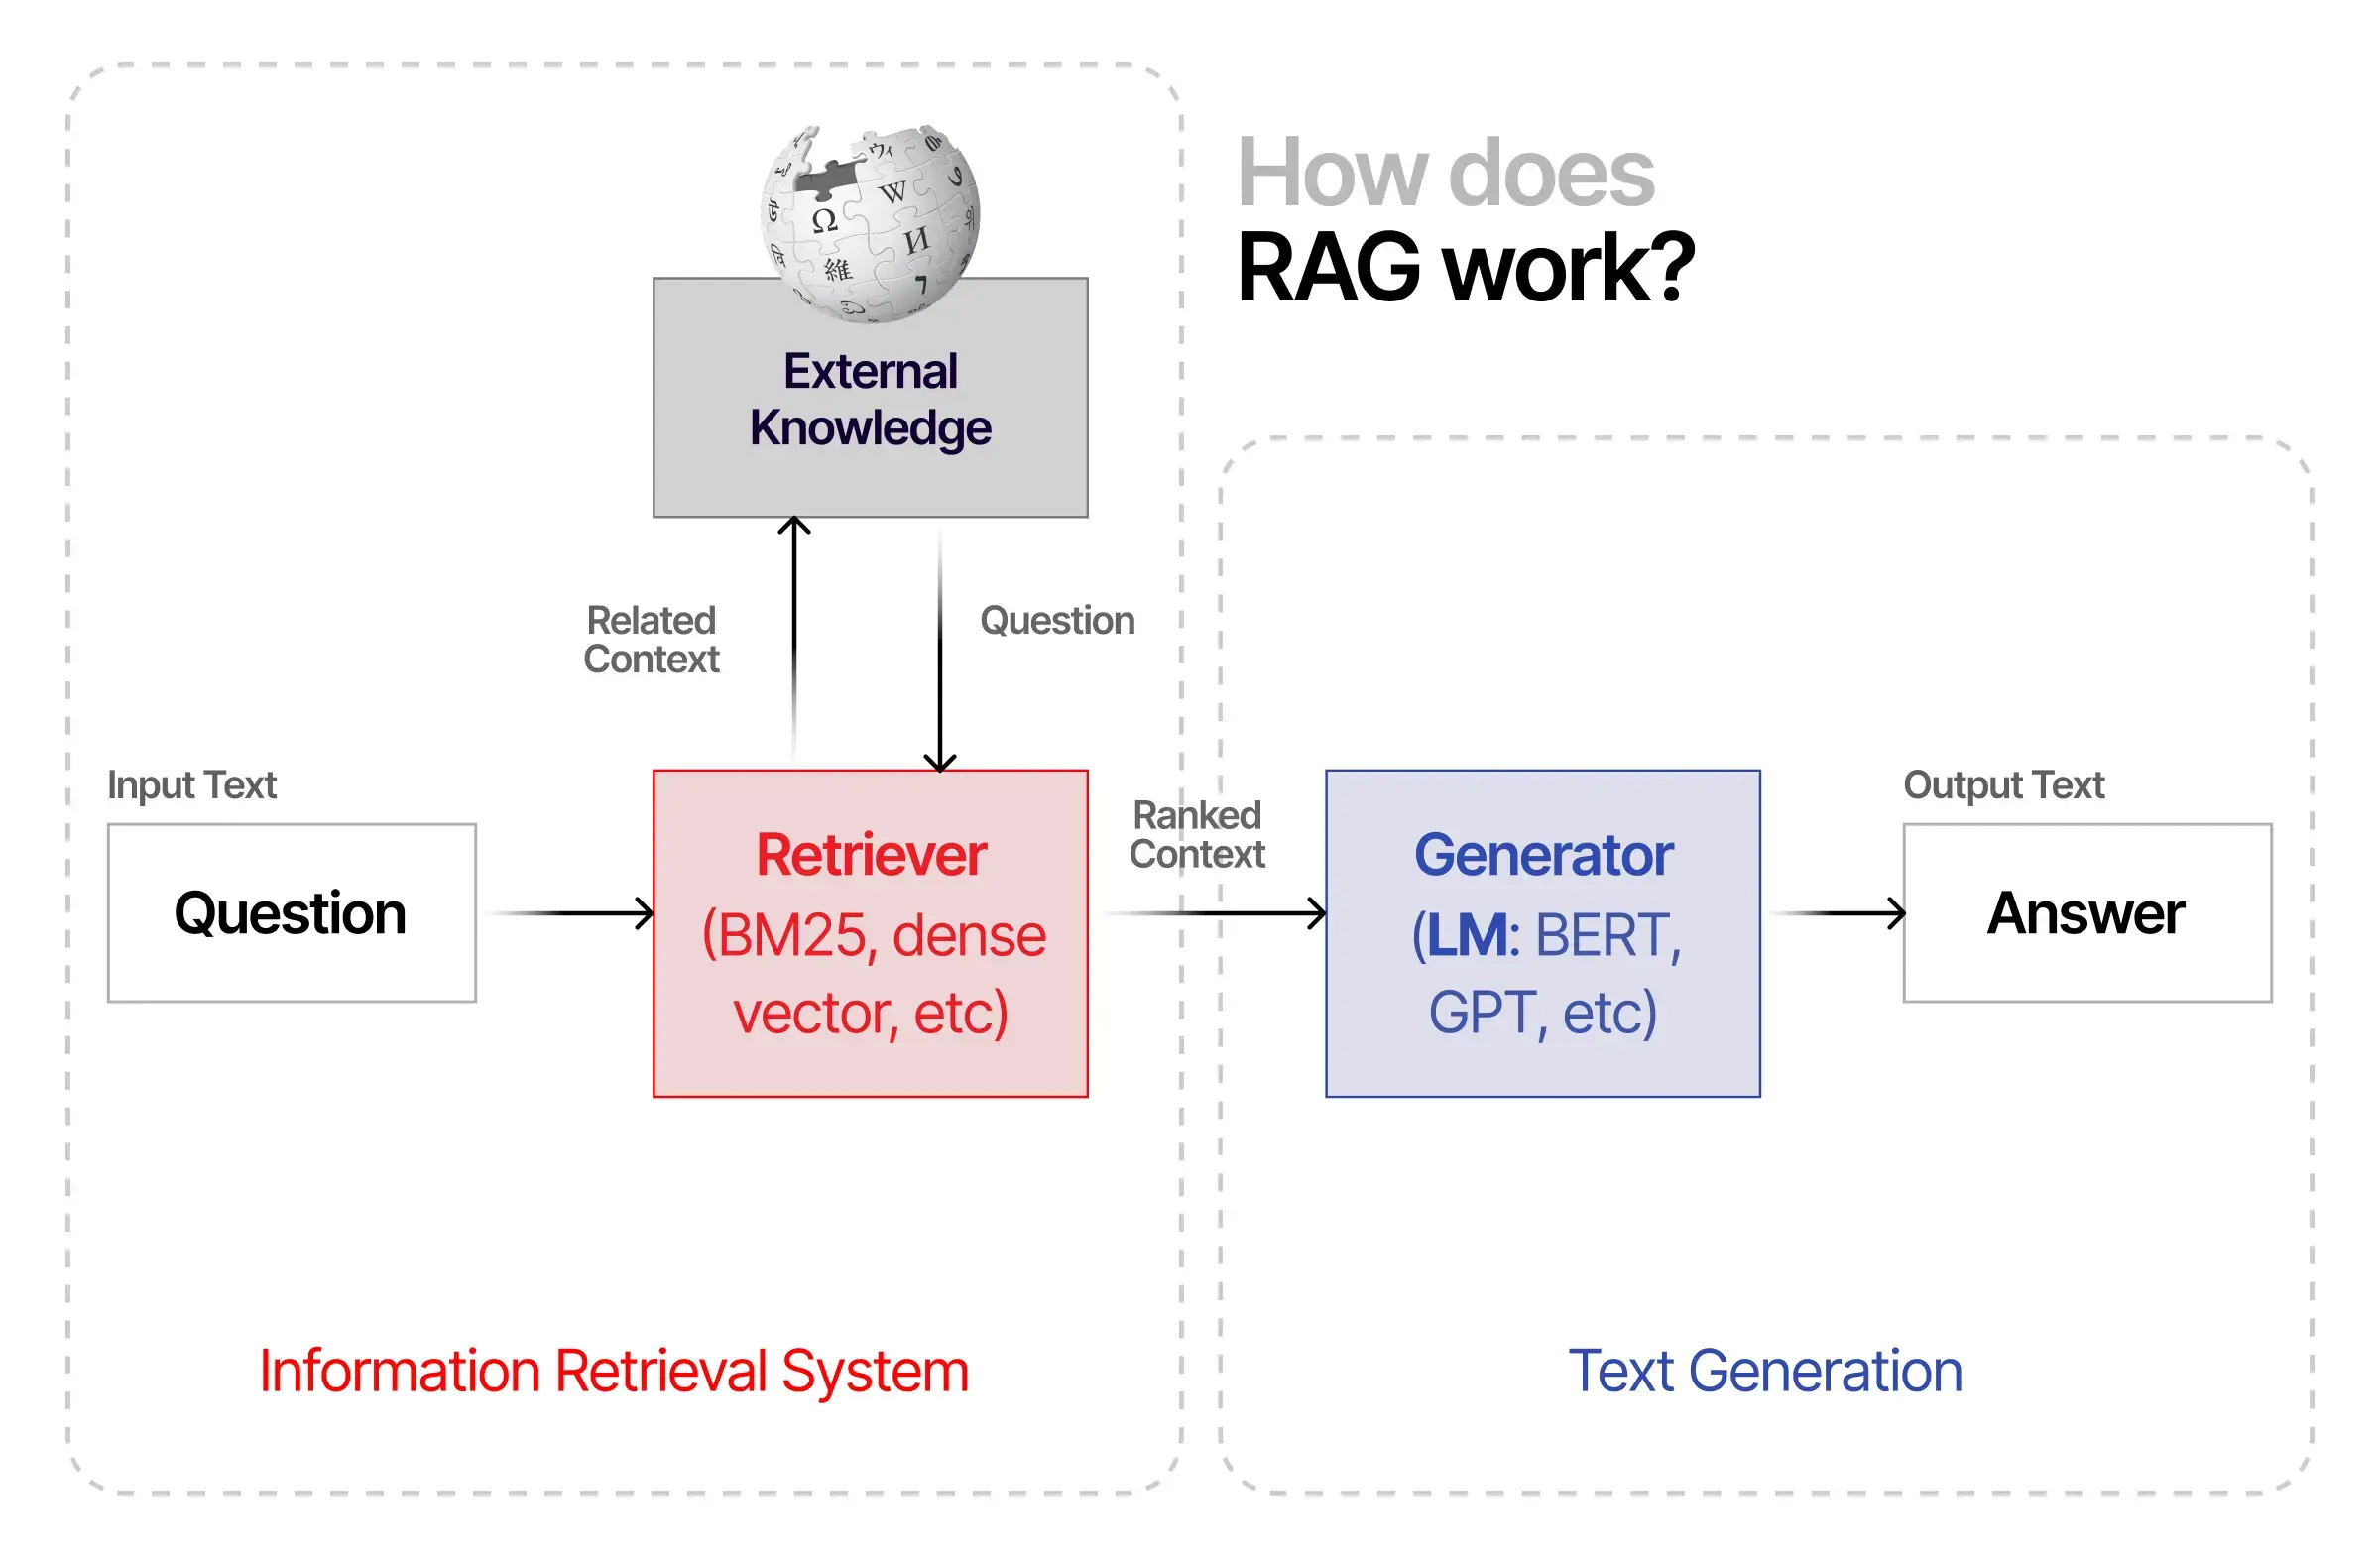